# EMIT

## Install package with EMIT dependecies 

```
pip install git+https://github.com/spaceml-org/georeader#egg=georeader[emit]
```

## Download an EMIT image

In [2]:
from georeader.readers import emit
from georeader.readers import download_utils
import os

dir_emit_files = "emit_database/raw"
os.makedirs(dir_emit_files, exist_ok=True)
# link = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220828T051941_2224004_006/EMIT_L1B_RAD_001_20220828T051941_2224004_006.nc'
link = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220827T060753_2223904_013/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc'
file_save = os.path.join(dir_emit_files, os.path.basename(link))

emit.download_product(link, file_save)

  0%|                                              | 0.00/1.85G [00:00<?, ?iB/s]
  0%|                                   | 8.19k/1.85G [00:00<7:50:48, 65.5kiB/s]
  0%|                                    | 57.3k/1.85G [00:00<2:01:06, 255kiB/s]
  0%|                                     | 123k/1.85G [00:00<1:22:35, 374kiB/s]
  0%|                                       | 303k/1.85G [00:00<39:14, 786kiB/s]
  0%|                                      | 614k/1.85G [00:00<22:19, 1.38MiB/s]
  0%|                                     | 1.25M/1.85G [00:00<11:48, 2.61MiB/s]
  0%|                                     | 2.29M/1.85G [00:00<06:31, 4.72MiB/s]
  0%|                                     | 2.96M/1.85G [00:00<05:52, 5.24MiB/s]
  0%|                                     | 4.25M/1.85G [00:01<04:08, 7.42MiB/s]
  0%|                                     | 5.04M/1.85G [00:01<04:31, 6.79MiB/s]
  0%|▏                                    | 6.50M/1.85G [00:01<03:27, 8.90MiB/s]
  0%|▏                      

'emit_database/raw/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc'

## Create and inspec emit object

EMIT objects let you open an EMIT nc file without loading the content of the file in memory. The object in the cell below has 285 spectral bands. For the API description of the EMIT class see [the emit module](https://github.com/spaceml-org/georeader/blob/main/georeader/readers/emit.py). Since the object follows the API of georeader, you can read from the rasters using the functions from the [read](https://github.com/spaceml-org/georeader/blob/main/georeader/read.py) module.

In [3]:
# file_save = "emit_database/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc"
ei = emit.EMITImage(file_save)
ei

 
         File: emit_database/raw/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc
         Transform: | 0.00,-0.00, 61.16|
|-0.00,-0.00, 36.83|
| 0.00, 0.00, 1.00|
         Shape: (285, 2007, 2239)
         Resolution: (0.0005422325202530942, 0.0005422325202530942)
         Bounds: (61.1592142222353, 35.74201728362127, 62.3732728350893, 36.8302779517758)
         CRS: EPSG:4326
         units: uW/cm^2/SR/nm
        

In [4]:
import geopandas as gpd

gpd.GeoDataFrame(geometry=[ei.footprint()],
                 crs=ei.crs).explore()

## Load RGB

Select the RGB bands, we see that the raster has only 3 channels now (see Shape in the output of the cell below). The `ei` object has an attribute called `wavelengths` with the central wavelength of the hyperspectral band.

In [5]:
import numpy as np
wavelengths_read = np.array([640, 550, 460])

bands_read = np.argmin(np.abs(wavelengths_read[:, np.newaxis] - ei.wavelengths), axis=1).tolist()
ei_rgb = ei.read_from_bands(bands_read)
ei_rgb

 
         File: emit_database/raw/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc
         Transform: | 0.00,-0.00, 61.16|
|-0.00,-0.00, 36.83|
| 0.00, 0.00, 1.00|
         Shape: (3, 2007, 2239)
         Resolution: (0.0005422325202530942, 0.0005422325202530942)
         Bounds: (61.1592142222353, 35.74201728362127, 62.3732728350893, 36.8302779517758)
         CRS: EPSG:4326
         units: uW/cm^2/SR/nm
        

In [12]:
bands_read

[35, 23, 11]

In [6]:
ei_rgb.wavelengths

array([641.2759 , 551.8667 , 462.59888], dtype=float32)

In [7]:
ei_rgb_local = ei_rgb.load()
ei_rgb_local

 
         Transform: | 0.00,-0.00, 61.16|
|-0.00,-0.00, 36.83|
| 0.00, 0.00, 1.00|
         Shape: (3, 2007, 2239)
         Resolution: (0.0005422325202530942, 0.0005422325202530942)
         Bounds: (61.1592142222353, 35.74201728362127, 62.3732728350893, 36.8302779517758)
         CRS: EPSG:4326
         fill_value_default: -9999.0
        

<Axes: >

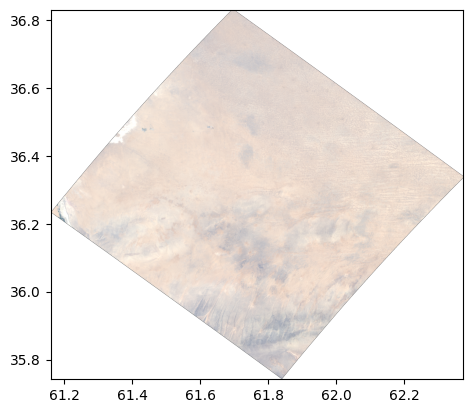

In [8]:
from georeader.plot import show

show((ei_rgb_local / 12).clip(0,1), 
     mask=ei_rgb_local.values == ei_rgb_local.fill_value_default)

## Reproject to UTM


In [9]:
import georeader

crs_utm = georeader.get_utm_epsg(ei.footprint("EPSG:4326"))
emit_image_utm = ei.to_crs(crs_utm)
emit_image_utm_rgb = emit_image_utm.read_from_bands(bands_read)
emit_image_utm_rgb_local = emit_image_utm_rgb.load()

emit_image_utm_rgb_local

 
         Transform: | 60.00, 0.00, 333546.51|
| 0.00,-60.00, 4077625.88|
| 0.00, 0.00, 1.00|
         Shape: (3, 2036, 1844)
         Resolution: (60.0, 60.0)
         Bounds: (333546.5136802632, 3955465.8769401284, 444186.5136802632, 4077625.8769401284)
         CRS: EPSG:32641
         fill_value_default: -9999.0
        

<Axes: >

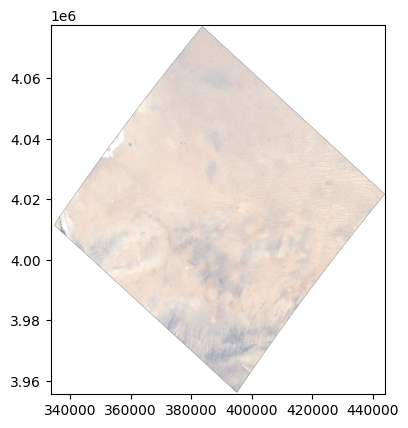

In [10]:
show((emit_image_utm_rgb_local / 12).clip(0,1), 
     mask=emit_image_utm_rgb_local.values == emit_image_utm_rgb_local.fill_value_default)

## Load image non-orthorectified

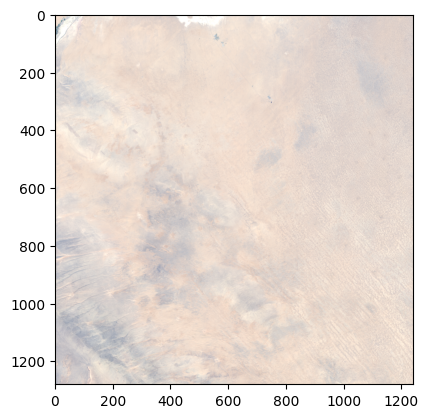

In [11]:
import matplotlib.pyplot as plt

ei_rgb_raw = ei_rgb.load_raw()
plt.imshow((ei_rgb_raw/12).clip(0,1).transpose(1,2,0))